In [1]:
!pip install keras
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.6 MB/s eta 0:00:00


In [2]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


# Tools & libraries

In [3]:
import numpy as np 
import pandas as pd 
import os
import re
import csv
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import contractions
import warnings 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Get the data

In [4]:
data = pd.read_csv("/kaggle/input/sexism/sexism_data.csv")
data.head()

,id,dataset,text,toxicity,sexist,of_id
0,0,other,MENTION3481 i didn't even know random was an o...,0.118180,False,-1
1,1,other,Bottom two should've gone! #mkr,0.251850,False,-1
2,2,callme,MENTION3111 MENTION3424 ladyboner deserves so ...,0.113331,False,-1
3,3,other,She shall now be known as Sourpuss #MKR #KatAn...,0.531153,False,-1
4,4,other,Tarah W threw a bunch of women under the bus s...,0.118718,False,-1


In [5]:
print(data['sexist'].value_counts())

False    11822
True      1809
Name: sexist, dtype: int64


# Clean the data

In [6]:
def clean_text(text):
    text = text.lower()#convert the text to lower
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')#remove urls
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))#remove account handles
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()

    text = re.sub(r"im", "i'm", text)
    text = re.sub(r"hes", "he's", text)
    text = re.sub(r"shes", "she's", text)
    text = re.sub(r"thats", "that's", text)        
    text = re.sub(r"whats", "what's", text)
    text = re.sub(r"wheres", "where's", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"wont", "won't", text)
    text = re.sub(r"dont", "don't", text)
    text = re.sub(r"didnt", "didn't", text)
    text = re.sub(r"cant", "can't", text)
    text = re.sub(r"its", "it's", text)
    text = re.sub(r"couldnt", "couldn't", text)
    text = re.sub(r"havent", "haven't", text)
    text = re.sub(r"shouldnt", "shouldn't", text)
    text = contractions.fix(text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

# Tokenization

In [7]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(data):
    head_lines = list()
    lines = data["text"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['even', 'know', 'random', 'option'],
 ['bottom', 'two', 'gone', 'mkr'],
 ['ladyboner',
  'deserves',
  'much',
  'credit',
  'dudeboner',
  'bonerdebate',
  'reddetails'],
 ['shall', 'known', 'sourpuss', 'mkr', 'katandre', 'failedfoodies'],
 ['tarah',
  'w',
  'threw',
  'bunch',
  'women',
  'bus',
  'could',
  'get',
  'wadhwas',
  'support',
  'women',
  'tech',
  'book'],
 ['trust', 'adult', 'uses', 'coupons'],
 ['mkr'],
 ['returns',
  'couples',
  'intruders',
  'gate',
  'crashers',
  'secondchancers',
  'eliminated',
  'mkr'],
 ['abuse', 'comes', 'gamergate', 'accounts', 'days', 'old'],
 ['great',
  'see',
  'local',
  'national',
  'park',
  'workers',
  'tucking',
  'free',
  'feed',
  'empty',
  'loos',
  'instead',
  'mkr']]

# Adding POS tags to the generated tokens 

In [8]:
import nltk

# download the necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# perform POS tagging on each sentence in head_lines
pos_tagged_head_lines = []
for text in head_lines:
    pos_tagged_sentence = nltk.pos_tag(text)#function uses the Penn Treebank tagset by default
    pos_tagged_head_lines.append(pos_tagged_sentence)

print(pos_tagged_head_lines[0:10])
#"NN" for singular nouns, "VB" for verbs, "JJ" for adjectives

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[[('even', 'RB'), ('know', 'VBP'), ('random', 'NN'), ('option', 'NN')], [('bottom', 'NN'), ('two', 'CD'), ('gone', 'VBN'), ('mkr', 'NN')], [('ladyboner', 'NN'), ('deserves', 'NNS'), ('much', 'JJ'), ('credit', 'NN'), ('dudeboner', 'NN'), ('bonerdebate', 'NN'), ('reddetails', 'NNS')], [('shall', 'MD'), ('known', 'VBN'), ('sourpuss', 'VB'), ('mkr', 'JJ'), ('katandre', 'NN'), ('failedfoodies', 'NNS')], [('tarah', 'NN'), ('w', 'NN'), ('threw', 'VBD'), ('bunch', 'JJ'), ('women', 'NNS'), ('bus', 'NN'), ('could', 'MD'), ('get', 'VB'), ('wadhwas', 'JJ'), ('support', 'NN'), ('women', 'NNS'), ('tech', 'VBP'), ('book', 'NN')], [('trust', 'NN'), ('adult', 'NN'), ('uses', 'VBZ'), ('coupons', 'NNS

# Visualize the most occuring words

(-0.5, 499.5, 349.5, -0.5)

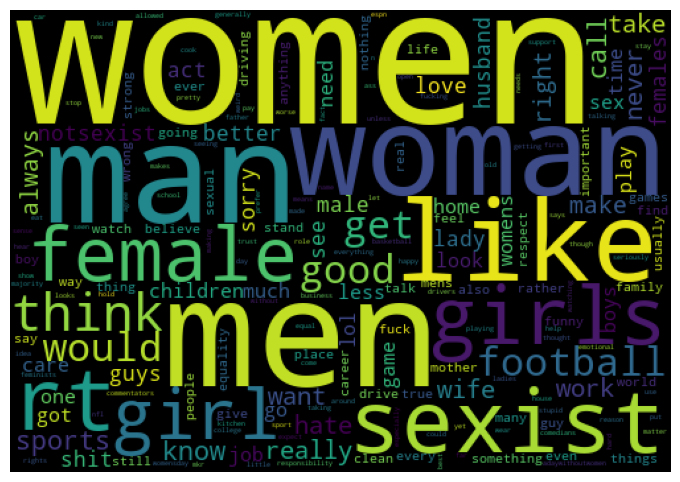

In [9]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['sexist'] == True]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 500, height = 350).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")

# Train-test split

In [10]:
validation_split = 0.2
max_length = 100


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['sexist'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  13687
vocab size - 13688


In [11]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (10905, 100)
Shape of y_train: (10905,)
Shape of X_test_pad: (2726, 100)
Shape of y_test: (2726,)


# GloVe model

In [12]:
embeddings_index = {}
embedding_dim = 100
with open(os.path.join('/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt'), encoding = "utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


# Extract features

In [13]:
import numpy as np

# Define a function to extract features from a list of preprocessed text using the GloVe embeddings
def extract_features(text, embeddings_index, embedding_dim):
    # Initialize the feature vector with zeros
    feature_vec = np.zeros((embedding_dim,))
    # Initialize a counter for the number of words
    n_words = 0
    # Loop over each word in the text
    for word in text:
        # Check if the word is in the embeddings index
        if word in embeddings_index:
            # Add the word vector to the feature vector
            feature_vec += embeddings_index[word]
            # Increment the word counter
            n_words += 1
    # Divide the feature vector by the number of words to get the average
    if n_words > 0:
        feature_vec /= n_words
    return feature_vec

# Set the embedding dimension
embedding_dim = 100

# Apply the extract_features function to the 'text' column
data['features'] = data['text'].apply(lambda text: extract_features(text.split(), embeddings_index, embedding_dim))
print(data["features"])

0        [0.1423039654813086, 0.570670003692309, 0.0131...
1        [0.7064700126647949, -0.2922399938106537, 0.15...
2        [-0.30018128401466776, 0.06442828902176448, 0....
3        [0.19810400307178497, 0.08946599587798118, -0....
4        [0.09895681124180555, 0.14952931739389896, 0.1...
                               ...                        
13626    [0.12653044473308211, 0.26456384418102413, 0.2...
13627    [-0.07212439924478531, -0.23047230187803508, -...
13628    [-0.4073300063610077, 1.0976999998092651, 0.06...
13629    [0.054031917514900364, 0.08338078406328957, 0....
13630    [0.020623445172201504, 0.10602027584205974, 0....
Name: features, Length: 13631, dtype: object


# Logistic Regression Model


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the logistic regression model
lr_model = LogisticRegression()

# Train the model on the training set
lr_model.fit(X_train_pad, y_train)

# Predict the labels for the test set
y_pred = lr_model.predict(X_test_pad)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))


Accuracy: 86.87%


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Naive Bayes Model

In [15]:
df = pd.read_csv("/kaggle/input/sexism/sexism_data.csv")

In [16]:
df["sexist"] = df["sexist"].map({False: "Not misogynist", True: "is misogynist"})

print(df.head())

   id dataset                                               text  toxicity  \
0   0   other  MENTION3481 i didn't even know random was an o...  0.118180   
1   1   other                   Bottom two should've gone!  #mkr  0.251850   
2   2  callme  MENTION3111 MENTION3424 ladyboner deserves so ...  0.113331   
3   3   other  She shall now be known as Sourpuss #MKR #KatAn...  0.531153   
4   4   other  Tarah W threw a bunch of women under the bus s...  0.118718   

           sexist  of_id  
0  Not misogynist     -1  
1  Not misogynist     -1  
2  Not misogynist     -1  
3  Not misogynist     -1  
4  Not misogynist     -1  


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
df = df[["text", "sexist"]]
x = np.array(df["text"])
y = np.array(df["sexist"])

cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
X_trainNB, X_testNB, y_trainNB, y_testNB = train_test_split(X, y, test_size=0.60, random_state=30)

In [18]:
modelNB = BernoulliNB()
modelNB.fit(X_trainNB, y_trainNB)
print(modelNB.score(X_testNB, y_testNB))

0.8696662183641032


# Build the embedding layer

In [19]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

11609


In [20]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

# Build the RNN (Bidirectional LSTM)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Bidirectional, Dropout

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.1)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print('Summary of the built model...')
print(model.summary())


Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1368800   
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)        

## *Training*

In [22]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=15, validation_data=(X_test_pad, y_test), verbose=2)


Epoch 1/15
86/86 - 29s - loss: 0.3560 - acc: 0.8591 - val_loss: 0.2606 - val_acc: 0.8679 - 29s/epoch - 332ms/step
Epoch 2/15
86/86 - 12s - loss: 0.2411 - acc: 0.8851 - val_loss: 0.2355 - val_acc: 0.8944 - 12s/epoch - 136ms/step
Epoch 3/15
86/86 - 11s - loss: 0.1875 - acc: 0.9110 - val_loss: 0.2240 - val_acc: 0.8999 - 11s/epoch - 126ms/step
Epoch 4/15
86/86 - 11s - loss: 0.1374 - acc: 0.9405 - val_loss: 0.2597 - val_acc: 0.8977 - 11s/epoch - 130ms/step
Epoch 5/15
86/86 - 11s - loss: 0.1129 - acc: 0.9538 - val_loss: 0.3239 - val_acc: 0.8962 - 11s/epoch - 127ms/step
Epoch 6/15
86/86 - 11s - loss: 0.0774 - acc: 0.9721 - val_loss: 0.3208 - val_acc: 0.8951 - 11s/epoch - 129ms/step
Epoch 7/15
86/86 - 11s - loss: 0.0629 - acc: 0.9783 - val_loss: 0.3575 - val_acc: 0.8955 - 11s/epoch - 134ms/step
Epoch 8/15
86/86 - 11s - loss: 0.0459 - acc: 0.9841 - val_loss: 0.3168 - val_acc: 0.8877 - 11s/epoch - 127ms/step
Epoch 9/15
86/86 - 11s - loss: 0.0359 - acc: 0.9888 - val_loss: 0.4069 - val_acc: 0.8925

In [23]:
for epoch, acc in enumerate(history.history['acc']):
    print("Epoch {}: training accuracy = {:.4f}".format(epoch+1, acc))

Epoch 1: training accuracy = 0.8591
Epoch 2: training accuracy = 0.8851
Epoch 3: training accuracy = 0.9110
Epoch 4: training accuracy = 0.9405
Epoch 5: training accuracy = 0.9538
Epoch 6: training accuracy = 0.9721
Epoch 7: training accuracy = 0.9783
Epoch 8: training accuracy = 0.9841
Epoch 9: training accuracy = 0.9888
Epoch 10: training accuracy = 0.9864
Epoch 11: training accuracy = 0.9892
Epoch 12: training accuracy = 0.9924
Epoch 13: training accuracy = 0.9931
Epoch 14: training accuracy = 0.9936
Epoch 15: training accuracy = 0.9935


In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

# Print the test accuracy
print('Test accuracy:', test_accuracy)


Test accuracy: 0.9020543098449707


## *Visualize the learning*

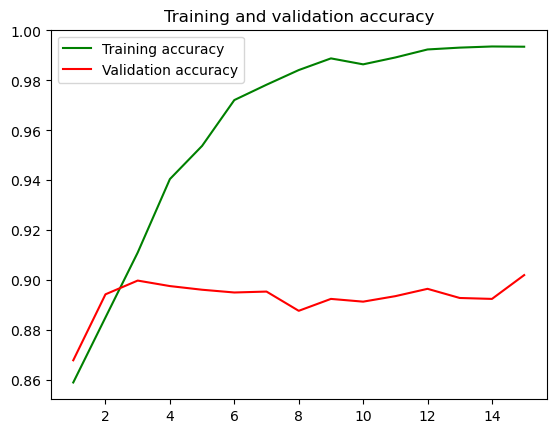

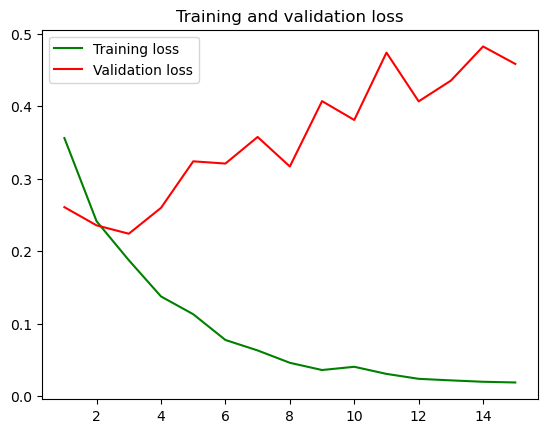

In [25]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<hr>
<h2><i>Can this model detect Misogyny?</i></h2>

In [26]:
def detect_misogyny(s):
    x_final = pd.DataFrame({"text":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    y_pred =model.predict(test_review_pad)
    y_pred*=100
    if y_pred[0][0]>=87:
        print(y_pred[0][0]) 
        return "You're a misogynist" 
    else: return "You're good to go."

### *Correct guesses*

In [27]:
detect_misogyny("Why do women want to study? they have to get married and cook in the kitchen later on")

1/1 [==============================] - 1s 576ms/step
99.33819


"You're a misogynist"

In [28]:
detect_misogyny("Don’t talk about periods in front of men in the house. It is shameful.")



1/1 [==============================] - 0s 26ms/step
96.15635


"You're a misogynist"

In [30]:
detect_misogyny("girls cant drive")

1/1 [==============================] - 0s 26ms/step
93.58936


"You're a misogynist"

In [31]:
detect_misogyny("women cant play sports")

1/1 [==============================] - 0s 26ms/step
99.96399


"You're a misogynist"

In [32]:
detect_misogyny("girls should not wear short clothes")



1/1 [==============================] - 0s 26ms/step
97.64505


"You're a misogynist"

In [33]:
detect_misogyny("boys will be boys")


1/1 [==============================] - 0s 27ms/step
91.19183


"You're a misogynist"

In [34]:
detect_misogyny("let the men handle the technical ppts")

1/1 [==============================] - 0s 25ms/step
99.962425


"You're a misogynist"

In [35]:
detect_misogyny("you look beautiful today")

1/1 [==============================] - 0s 25ms/step


"You're good to go."

In [36]:
detect_misogyny("the girls of this batch are very smart")

1/1 [==============================] - 0s 26ms/step


"You're good to go."